Used the pre-trained glove embedding model in this trial.
Add Convolution layers.
Change tanh to sigmoid

In [3]:
import read_data 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.io.pickle import to_pickle, read_pickle
save_dir = 'text_classifier4/'
import os
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [4]:
#%% imbeding vectors
#download
glove_dir = 'glove_data/'
if not os.path.exists(glove_dir):
    os.mkdir(glove_dir)
if not os.path.exists(glove_dir+'glove.6B.zip'):
    import subprocess
    subprocess.run(["wget",'-P'+glove_dir, "http://nlp.stanford.edu/data/glove.6B.zip"])
    print('downloaded')
if not os.path.exists(glove_dir+'glove.6B.50d.txt'):
    import zipfile
    zip_ref = zipfile.ZipFile(glove_dir+'glove.6B.zip', 'r')
    zip_ref.extractall(glove_dir)
    zip_ref.close()
    print('unziped')

In [5]:
embeddings_index = {}
with open(glove_dir+'glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
#%% first steps
books,genre,excerpt = read_data.read_text_data()
id_train,id_val = read_data.read_ids()

MAX_WORDS = 8000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(excerpt.values())
sequences = tokenizer.texts_to_sequences(excerpt.values())

word_index = tokenizer.word_index
to_pickle(tokenizer, save_dir+'text_tokenizer.pickle')
print(len(word_index))


169991


(0, 10000)

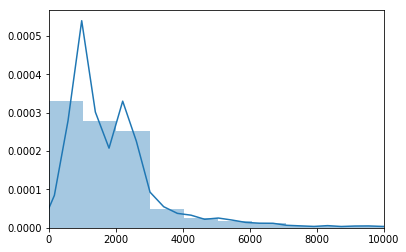

In [7]:
lens = [len(s) for s in sequences]
sns.distplot(lens)
plt.xlim((0,10000))

In [8]:
MAXLEN = 4000
data = pad_sequences(sequences, maxlen=MAXLEN)

#labels = to_categorical(np.asarray(labels))
labels = ['Fiction' in genre[id] for id in excerpt.keys()]
labels = np.array(labels).reshape((-1,1))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (4166, 4000)
Shape of label tensor: (4166, 1)


In [9]:
# split the data into a training set and a validation set

train_index = [id in id_train for id in excerpt.keys()]
val_index = [id in id_val for id in excerpt.keys()]
x_train = data[train_index]
y_train = labels[train_index]
x_val = data[val_index]
y_val = labels[val_index]
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

to_pickle((x_train, y_train, x_val, y_val),save_dir+'text_dataset.pc')

(2922, 4000) (2922, 1) (1244, 4000) (1244, 1)


In [10]:
# prepare embedding layer
embedding_vecor_length = 50 # this is determined by the glove data!!!
num_words = min(MAX_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, embedding_vecor_length))
for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            embedding_vecor_length,
                            weights=[embedding_matrix],
                            input_length=MAXLEN,
                            trainable=False)

In [11]:

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(50,dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

checkpoint = ModelCheckpoint(save_dir+"text_best_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
with open(save_dir+'text_csvlogger.csv','w') as f:
    f.write('')
csvlog = CSVLogger(save_dir+'text_csvlogger.csv',append=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4000, 50)          400000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3998, 32)          4832      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1999, 32)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               33200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 438,133
Trainable params: 38,133
Non-trainable params: 400,000
_________________________________________________________________
None


In [12]:
model.fit(x_train, y_train, epochs=5, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

#scores = model.evaluate(x_val, y_val, verbose=0)
#print("Accuracy: %f%%" % (scores[1]*100))

model.save(save_dir+'text_last_model.h5')
print(checkpoint.best)

Train on 2922 samples, validate on 1244 samples
Epoch 1/5
2922/2922 [==============================] - 168s - loss: 0.6518 - acc: 0.6359 - val_loss: 0.6185 - val_acc: 0.6624
Epoch 2/5
2922/2922 [==============================] - 169s - loss: 0.5907 - acc: 0.6708 - val_loss: 0.4847 - val_acc: 0.7444
Epoch 3/5
2922/2922 [==============================] - 169s - loss: 0.5392 - acc: 0.7146 - val_loss: 0.5402 - val_acc: 0.7580
Epoch 4/5
2922/2922 [==============================] - 169s - loss: 0.5359 - acc: 0.7286 - val_loss: 0.4484 - val_acc: 0.7629
Epoch 5/5
2922/2922 [==============================] - 169s - loss: 0.4928 - acc: 0.7502 - val_loss: 0.4317 - val_acc: 0.7765
0.776527331381


In [13]:
#%% continue training

#model = load_model(save_dir+'text_last_model.h5')
#x_train, y_train, x_val, y_val = read_pickle(save_dir+'text_dataset.pc')

model.fit(x_train, y_train, epochs=5, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

model.save(save_dir+'text_last_model.h5')
print(checkpoint.best)

Train on 2922 samples, validate on 1244 samples
Epoch 1/5
2922/2922 [==============================] - 169s - loss: 0.4803 - acc: 0.7611 - val_loss: 0.4229 - val_acc: 0.7797
Epoch 2/5
2922/2922 [==============================] - 169s - loss: 0.4948 - acc: 0.7567 - val_loss: 0.4151 - val_acc: 0.8047
Epoch 3/5
2922/2922 [==============================] - 171s - loss: 0.4867 - acc: 0.7543 - val_loss: 0.4592 - val_acc: 0.7556
Epoch 4/5
2922/2922 [==============================] - 171s - loss: 0.4924 - acc: 0.7598 - val_loss: 0.5468 - val_acc: 0.6977
Epoch 5/5
2922/2922 [==============================] - 171s - loss: 0.4668 - acc: 0.7779 - val_loss: 0.4091 - val_acc: 0.8023
0.804662379613


In [14]:
model.fit(x_train, y_train, epochs=5, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

model.save(save_dir+'text_last_model.h5')
print(checkpoint.best)

Train on 2922 samples, validate on 1244 samples
Epoch 1/5
2922/2922 [==============================] - 171s - loss: 0.4798 - acc: 0.7786 - val_loss: 0.5293 - val_acc: 0.7315
Epoch 2/5
2922/2922 [==============================] - 170s - loss: 0.4952 - acc: 0.7550 - val_loss: 0.4200 - val_acc: 0.7990
Epoch 3/5
2922/2922 [==============================] - 170s - loss: 0.4442 - acc: 0.7882 - val_loss: 0.4094 - val_acc: 0.8071
Epoch 4/5
2922/2922 [==============================] - 169s - loss: 0.4401 - acc: 0.7926 - val_loss: 0.4088 - val_acc: 0.8127
Epoch 5/5
2922/2922 [==============================] - 168s - loss: 0.4382 - acc: 0.8001 - val_loss: 0.3953 - val_acc: 0.8111
0.812700964822


In [15]:
model.fit(x_train, y_train, epochs=50, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

model.save(save_dir+'text_last_model.h5')
print(checkpoint.best)

Train on 2922 samples, validate on 1244 samples
Epoch 1/50
2922/2922 [==============================] - 168s - loss: 0.5072 - acc: 0.7690 - val_loss: 0.4624 - val_acc: 0.7902
Epoch 2/50
2922/2922 [==============================] - 168s - loss: 0.4507 - acc: 0.7871 - val_loss: 0.4250 - val_acc: 0.8023
Epoch 3/50
2922/2922 [==============================] - 169s - loss: 0.4334 - acc: 0.7981 - val_loss: 0.4057 - val_acc: 0.8151
Epoch 4/50
2922/2922 [==============================] - 169s - loss: 0.4147 - acc: 0.8101 - val_loss: 0.3972 - val_acc: 0.8223
Epoch 5/50
2922/2922 [==============================] - 170s - loss: 0.4837 - acc: 0.7440 - val_loss: 0.4761 - val_acc: 0.7307
Epoch 6/50
2922/2922 [==============================] - 170s - loss: 0.4552 - acc: 0.7741 - val_loss: 0.3934 - val_acc: 0.8135
Epoch 7/50
2922/2922 [==============================] - 169s - loss: 0.4099 - acc: 0.8084 - val_loss: 0.4033 - val_acc: 0.8175
Epoch 8/50
2922/2922 [==============================] - 169s - 

2922/2922 [==============================] - 169s - loss: 0.3777 - acc: 0.8279 - val_loss: 0.3857 - val_acc: 0.8248
Epoch 34/50
2922/2922 [==============================] - 169s - loss: 0.3963 - acc: 0.8142 - val_loss: 0.3912 - val_acc: 0.8240
Epoch 35/50
2922/2922 [==============================] - 169s - loss: 0.3669 - acc: 0.8299 - val_loss: 0.3726 - val_acc: 0.8328
Epoch 36/50
2922/2922 [==============================] - 168s - loss: 0.3729 - acc: 0.8320 - val_loss: 0.3829 - val_acc: 0.8240
Epoch 37/50
2922/2922 [==============================] - 168s - loss: 0.3702 - acc: 0.8289 - val_loss: 0.3860 - val_acc: 0.8248
Epoch 38/50
2922/2922 [==============================] - 168s - loss: 0.3685 - acc: 0.8268 - val_loss: 0.3875 - val_acc: 0.8191
Epoch 39/50
2922/2922 [==============================] - 168s - loss: 0.3635 - acc: 0.8368 - val_loss: 0.3763 - val_acc: 0.8368
Epoch 40/50
2922/2922 [==============================] - 169s - loss: 0.3578 - acc: 0.8450 - val_loss: 0.3887 - val_